<a href="https://colab.research.google.com/github/PranavShashidhara/Movie-Recommendation-system/blob/main/RBM_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install scipy

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

from scipy.sparse import lil_matrix, csr_matrix, save_npz, load_npz

def one_hot_encoding(X, K): # we are not using the inbuilt function as it takes in only a 2d matrix and gives a 2d output
   N, D = X.shape
   Y = np.zeros((N, D, K)) # Samples, features, class
   for n, d in zip(*X.nonzero()):
    k = int(X[n, d]*2 - 1) # 0.5...5 --> 1..10 -->0..9
    Y[n,d,k] = 1 # scipy supports sparse matrices for multiple dimensions but they are slower than normal numpy arrays
   return Y

def one_hot_mask(X, K): # it's not an actual one hot encoding, it is the original N by D maskk repeated K times.
  N, D = X.shape # if we a k sized vector with missing ratings we have to set those values to 0.
  Y = np.zeros((N, D, K))
  for n, d in zip(*X.nonzero()):
    Y[n,d,:] = 1
  return Y

one_to_ten = np.arange(10) + 1
def convert_probs_to_ratings(probs):
  return probs.dot(one_to_ten/10) # To convert the scale from 1..10 to 0.5 to 5

def dot1(V, W):
  # V is N * D * K
  # W is D * K * M
  # returns N * M (hidden layer size)
  return tf.tensordot(V, W, axes=[[1,2], [0,1]]) # matmul can't be used as it expects both arguments to be 2D tensors

def dot2(H, W):
  # H is N * M
  # W is D * K * M
  # returns N * D * K
  return tf.tensordot(H, W, axes=[[1], [2]])

In [15]:
class RBM(object):
    def __init__(self, D, M, K):
        self.D = D # input feature size
        self.M = M # hidden size
        self.K = K # number of ratings
        self.build(D, M, K)


    def build(self, D, M, K):
        # params
        self.W = tf.Variable(tf.random.normal(shape=(D, K, M)) * np.sqrt(2.0 / M))
        self.c = tf.Variable(np.zeros(M).astype(np.float32))
        self.b = tf.Variable(np.zeros((D, K)).astype(np.float32))

        # data
        self.X_in = tf.compat.v1.placeholder(tf.float32, shape=(None, D, K))
        self.mask = tf.compat.v1.placeholder(tf.float32, shape=(None, D, K))

        # conditional probabilities
        # NOTE: tf.contrib.distributions.Bernoulli API has changed in Tensorflow v1.2
        V = self.X_in
        p_h_given_v = tf.nn.sigmoid(dot1(V, self.W) + self.c)
        self.p_h_given_v = p_h_given_v # save for later

        # draw a sample from p(h | v)
        r = tf.random.uniform(shape=tf.shape(input=p_h_given_v))
        H = tf.cast(r < p_h_given_v, dtype=tf.float32)

        # draw a sample from p(v | h)
        # note: we don't have to actually do the softmax
        logits = dot2(H, self.W) + self.b
        cdist = tf.compat.v1.distributions.Categorical(logits=logits)
        X_sample = cdist.sample() # shape is (N, D)
        X_sample = tf.one_hot(X_sample, depth=K) # turn it into (N, D, K)
        X_sample = X_sample * self.mask # missing ratings shouldn't contribute to objective


        # build the objective
        objective = tf.reduce_mean(input_tensor=self.free_energy(self.X_in)) - tf.reduce_mean(input_tensor=self.free_energy(X_sample))
        self.train_op = tf.compat.v1.train.AdamOptimizer(1e-2).minimize(objective)
        # self.train_op = tf.train.GradientDescentOptimizer(1e-3).minimize(objective)

        # build the cost
        # we won't use this to optimize the model parameters
        # just to observe what happens during training
        logits = self.forward_logits(self.X_in)
        self.cost = tf.reduce_mean(
            input_tensor=tf.nn.softmax_cross_entropy_with_logits(
                labels=tf.stop_gradient(self.X_in),
                logits=logits,
            )
        )

        # to get the output
        self.output_visible = self.forward_output(self.X_in)

        initop = tf.compat.v1.global_variables_initializer()
        self.session = tf.compat.v1.Session()
        self.session.run(initop)

    def fit(self, X, mask, X_test, mask_test, epochs=10, batch_sz=256, show_fig=True):
        N, D = X.shape
        n_batches = N // batch_sz


        costs = []
        test_costs = []
        for i in range(epochs):
            print("epoch:", i)
            X, mask, X_test, mask_test = shuffle(X, mask, X_test, mask_test) # everything has to be shuffled accordingly
            for j in range(n_batches):
                x = X[j*batch_sz:(j*batch_sz + batch_sz)].toarray()
                m = mask[j*batch_sz:(j*batch_sz + batch_sz)].toarray()

                # both visible units and mask have to be in one-hot form
                # N x D --> N x D x K
                batch_one_hot = one_hot_encoding(x, self.K)
                m = one_hot_mask(m, self.K)

                _, c = self.session.run(
                    (self.train_op, self.cost),
                    feed_dict={self.X_in: batch_one_hot, self.mask: m}
                )

                if j % 100 == 0:
                    print("j / n_batches:", j, "/", n_batches, "cost:", c)

            # calculate the true train and test cost
            sse = 0
            test_sse = 0
            n = 0
            test_n = 0
            for j in range(n_batches):
                x = X[j*batch_sz:(j*batch_sz + batch_sz)].toarray()
                m = mask[j*batch_sz:(j*batch_sz + batch_sz)].toarray()

                # only visible input has to be in one-hot form
                xoh = one_hot_encoding(x, self.K)

                probs = self.get_visible(xoh)
                xhat = convert_probs_to_ratings(probs)
                sse += (m * (xhat - x)*(xhat - x)).sum()
                n += m.sum()

                # the test PREDICTIONS come from the train data!
                # X_test and mask_test are only used for targets
                xt = X_test[j*batch_sz:(j*batch_sz + batch_sz)].toarray()
                mt = mask_test[j*batch_sz:(j*batch_sz + batch_sz)].toarray()

                test_sse += (mt * (xhat - xt) * (xhat - xt)).sum()
                test_n += mt.sum()
            c = sse/n
            ct = test_sse/test_n
            print("train mse:", c)
            print("test mse:", ct)
            costs.append(c)
            test_costs.append(ct)
        if show_fig:
            plt.plot(costs, label='train mse')
            plt.plot(test_costs, label='test mse')
            plt.legend()
            plt.show()

    def free_energy(self, V):
        first_term = -tf.reduce_sum(input_tensor=dot1(V, self.b))
        second_term = -tf.reduce_sum(
            # tf.log(1 + tf.exp(tf.matmul(V, self.W) + self.c)),
            input_tensor=tf.nn.softplus(dot1(V, self.W) + self.c),
            axis=1
        )
        return first_term + second_term

    def forward_hidden(self, X):
        return tf.nn.sigmoid(dot1(X, self.W) + self.c)

    def forward_logits(self, X):
        Z = self.forward_hidden(X)
        return dot2(Z, self.W) + self.b

    def forward_output(self, X):
        return tf.nn.softmax(self.forward_logits(X))

    def transform(self, X):
        # accepts and returns a real numpy array
        # unlike forward_hidden and forward_output
        # which deal with tensorflow variables
        return self.session.run(self.p_h_given_v, feed_dict={self.X_in: X})

    def get_visible(self, X):
        return self.session.run(self.output_visible, feed_dict={self.X_in: X})

Free energy Equation
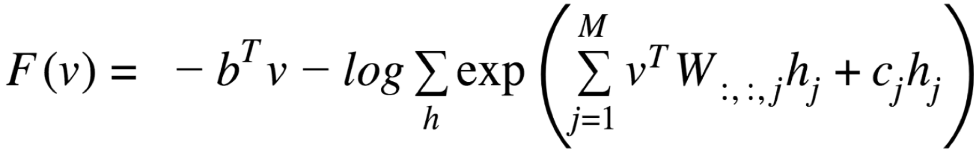

epoch: 0
j / n_batches: 0 / 3 cost: 0.8388175
train mse: 8.534973071824773
test mse: 8.551403667604298
epoch: 1
j / n_batches: 0 / 3 cost: 0.6805362
train mse: 8.234520132674765
test mse: 8.247366247536435
epoch: 2
j / n_batches: 0 / 3 cost: 0.6211557
train mse: 8.1859687776806
test mse: 8.193974406907847
epoch: 3
j / n_batches: 0 / 3 cost: 0.63191795
train mse: 8.162821403476492
test mse: 8.175623953102365
epoch: 4
j / n_batches: 0 / 3 cost: 0.6256793
train mse: 8.208231833280628
test mse: 8.228198120048763
epoch: 5
j / n_batches: 0 / 3 cost: 0.61015433
train mse: 8.19122086243345
test mse: 8.198164725764745
epoch: 6
j / n_batches: 0 / 3 cost: 0.6239044
train mse: 8.203066196942208
test mse: 8.225015023918564
epoch: 7
j / n_batches: 0 / 3 cost: 0.6047488
train mse: 8.25079022809677
test mse: 8.269604672580474
epoch: 8
j / n_batches: 0 / 3 cost: 0.5990824
train mse: 8.17768272972973
test mse: 8.196353493174877
epoch: 9
j / n_batches: 0 / 3 cost: 0.5952567
train mse: 8.209997338644802
t

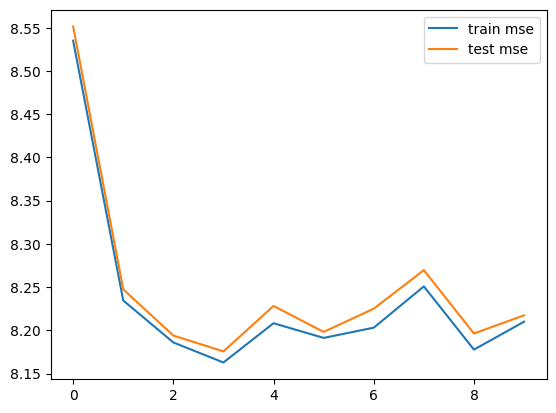

In [16]:

def main():
    A = load_npz("Atrain.npz")
    A_test = load_npz("Atest.npz")
    mask = (A > 0) * 1.0
    mask_test = (A_test > 0) * 1.0

    N, M = A.shape
    rbm = RBM(M, 50, 10)
    rbm.fit(A, mask, A_test, mask_test)


if __name__ == '__main__':
    main()